<a target="_blank" href="https://colab.research.google.com/github/cohere-ai/notebooks/blob/main/notebooks/Data_Analyst_Agent_Cohere_and_Langchain.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Tool Use - Simple Data Analyst Agent with Cohere and Langchain

Tool use is a method whichs allows developers to connect Cohere's Command models to external tools like search engines, APIs, databases, and other software tools. Just like how [Retrieval-Augmented Generation (RAG)](https://docs.cohere.com/docs/retrieval-augmented-generation-rag) allows a model to use an external data source to improve factual generation, tool use is a capability that allows retrieving data from multiple sources. But it goes beyond simply retrieving information and is able to use software tools to execute code, or even create entries in a CRM system.

In this notebook, we'll see how we can use two tools to create a simple data analyst agent that is able to search the web and run code in a python interpreter. This agent uses Cohere's Command R+ mode and Langchain.


![](https://raw.githubusercontent.com/cohere-ai/notebooks/main/notebooks/images/tool-use-notebook-header.png)

# Environment
Let's start by installing the required libraries

In [56]:
! pip install --quiet langchain langchain_cohere langchain_experimental

## Setup
We'll need a Cohere API key here. Grab your key and paste it in the next slide if you have one, or [register](https://dashboard.cohere.ai/welcome/register) and create a new API key.

In [57]:
### LLMs
import os
os.environ['COHERE_API_KEY'] = "LeznjRHhrexMn9J9e939vdfSSWlOS8WPDOENjOrB"
# source: https://dashboard.cohere.com/api-keys

In [58]:
# Create the Cohere chat model
from langchain_cohere.chat_models import ChatCohere
chat = ChatCohere(model="command-r-plus", temperature=0.3)

# Define tools
Our simple data analyst will be equipped with a web search tool, and a python interpreter (which we can use to run plotting code, for example).

### Web search
Let's first equip our agent with web search! We can use the Tivaly API for this. Head on to [tavily.com](https://tavily.com) and grab an API key to use here.

In [59]:
from langchain_community.tools.tavily_search import TavilySearchResults

os.environ['TAVILY_API_KEY'] = "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"

internet_search = TavilySearchResults()
internet_search.name = "internet_search"
internet_search.description = "Returns a list of relevant document snippets for a textual query retrieved from the internet."


# from langchain_core.pydantic_v1 import BaseModel, Field
from pydantic import Field
class TavilySearchInput(BaseModel):
    query: str = Field(description="Query to search the internet with")
internet_search.args_schema = TavilySearchInput

# source: https://app.tavily.com/home

In [60]:
internet_search.invoke({"query": "T5 BootCamp by SDAIA"}) # from here we can search as google do

[{'url': 'https://sdaia.gov.sa/en/Sectors/BuildingCapacity/academy/bootcamps/Pages/default.aspx',
  'content': "Explore the world of data science and AI at the SDAIA T5 Bootcamp. Dive into machine learning, large language models, data management, data governance, and more! SDAIA programs, SDAIA's academy programs, sdaia academy, sdaia bootcamp, bootcamp, sdaia internship, ai bootcamp, sdaia summer training, machine learning bootcamp, data management ..."},
 {'url': 'https://github.com/Manar-k/SDAIA-T5-Bootcamp-AI-and-Data-Science/blob/main/README.md',
  'content': 'SDAIA-T5-Bootcamp-AI-and-Data-Science \\n. Working on projects that mimic real-world business problems to help apply the concepts learned during this AI & Data Science SDAIA Bootcamp. \\n Data Science and Artificial Intelligence T5 \\n'},
 {'url': 'https://www.linkedin.com/posts/afafsalem_t5-t5bootcamp-sdaia-activity-7177718556212531200-fpxp',
  'content': 'Excited to have completed the second week of SDAIA | سدايا Data Scie

In [61]:
%pip install -qU duckduckgo-search langchain-community

In [62]:
from langchain_community.tools import DuckDuckGoSearchRun

search = DuckDuckGoSearchRun()

search.invoke("T5 BootCamp by SDAIA")

# source: https://python.langchain.com/docs/integrations/tools/ddg/

'salwaBukh/SDAIA_T5_AI_BOOTCAMP. This commit does not belong to any branch on this repository, and may belong to a fork outside of the repository. main. Switch branches/tags. Branches Tags. Could not load branches. Nothing to show {{ refName }} default View all branches. Could not load tags. Nothing to show T5 -تفاصيل ومشاريع ومنهج معسكر سدايا . Contribute to ii1nas/SDAIA-CAMP-T5 development by creating an account on GitHub. Riyadh: The Saudi Data and Artificial Intelligence Authority (SDAIA) has opened registration for the highly anticipated third phase of the "SDAIA T5" camps. These transformative camps aim to equip 250 national cadres with intensive educational paths in data science and artificial intelligence, empowering them to develop innovative solutions and applications in these fields. SDAIA\'s ALLaM-2-7B on Azure AI Model Catalog is a significant step forward in advancing Arabic Language Technology. This partnership between SDAIA and Microsoft ensures that enterprises, resear

### Python interpreter tool
Let's equip our agent with a python interpreter!

In [63]:
from langchain.agents import Tool
from langchain_experimental.utilities import PythonREPL

python_repl = PythonREPL()
repl_tool = Tool(
    name="python_repl",
    description="Executes python code and returns the result. The code runs in a static sandbox without interactive mode, so print output or save output to a file.",
    func=python_repl.run,
)
repl_tool.name = "python_interpreter"

# from langchain_core.pydantic_v1 import BaseModel, Field
class ToolInput(BaseModel):
    code: str = Field(description="Python code to execute.")
repl_tool.args_schema = ToolInput


# Create ReAct Agent: the data analyst

In [64]:
from langchain.agents import AgentExecutor
from langchain_cohere.react_multi_hop.agent import create_cohere_react_agent
from langchain_core.prompts import ChatPromptTemplate

In [65]:
# Create the prompt
prompt = ChatPromptTemplate.from_template("{input}")


# Create the ReAct agent
agent = create_cohere_react_agent(
    llm=chat,
    tools=[internet_search, repl_tool],
    prompt=prompt,
)

In [66]:
agent_executor = AgentExecutor(agent=agent, tools=[internet_search, repl_tool], verbose=True)

# Let's ask a question to the data analyst


First, I will search for the three tech companies with the highest market cap in the United States in 2024. Then, I will search for the number of full-time employees at each of these companies. Finally, I will use Python to create a plot of the number of full-time employees at these companies.
{'tool_name': 'internet_search', 'parameters': {'query': 'tech companies with highest market cap in the United States in 2024'}}
[{'url': 'https://disfold.com/united-states/sector/technology/companies/', 'content': 'Unlock Financial AI:\nStart your Free Trial of\nDisfold AI, Now!\nTop Technology Companies from the United States as of Jan. 01, 2024\n(Dec. 1, 2023)\nTop Technology Companies from the United States as of Jan. 01, 2024\n1.\nApple\nMarket Cap (USD):\n$2.866 T\nStock:\nAAPL\nwb_incandescent\nCountry:\nUnited States\nSector:\nTechnology\nIndustry:\nConsumer Electronics\n2.\nMicrosoft\nMarket Cap (USD):\n$2.755 T\nStock:\nMSFT\nwb_incandescent\nCountry:\nUnited States\nSector:\nTechnolog


I have found that Apple had 161,000 employees as of September 30, 2023. Microsoft had 228,000 employees as of June 30, 2024. Nvidia had 29,600 employees as of January 28, 2024. Now, I will use Python to create a plot of the number of full-time employees at these companies.
{'tool_name': 'python_interpreter', 'parameters': {'code': "import matplotlib.pyplot as plt\n\n# Data\ncompanies = ['Apple', 'Microsoft', 'Nvidia']\nnum_employees = [161000, 228000, 29600]\n\n# Plot\nplt.bar(companies, num_employees)\nplt.xlabel('Company')\nplt.ylabel('Number of Employees')\n\n# Save the plot\nplt.savefig('number_of_employees.png')"}}
Relevant Documents: 0,1,2,4,6,8,10,11,12,15,16,17,19
Cited Documents: 0,1,2,4,6,8,10,11,12,15,16,17,19
Answer: Here is a plot showing the number of full-time employees at the three tech companies with the highest market cap in the United States in 2024:

![Number of Employees](number_of_employees.png)
Grounded answer: Here is a plot showing the number of full-time empl

{'input': 'Create a plot of the number of full time employees at the three tech companies with the highest market cap in the United States in 2024.',
 'output': 'Here is a plot showing the number of full-time employees at the three tech companies with the highest market cap in the United States in 2024:\n\n! [Number of Employees](number_of_employees.png)',
 'citations': [CohereCitation(start=137, end=141, text='2024', documents=[{'url': 'https://disfold.com/united-states/sector/technology/companies/', 'content': 'Unlock Financial AI:\nStart your Free Trial of\nDisfold AI, Now!\nTop Technology Companies from the United States as of Jan. 01, 2024\n(Dec. 1, 2023)\nTop Technology Companies from the United States as of Jan. 01, 2024\n1.\nApple\nMarket Cap (USD):\n$2.866 T\nStock:\nAAPL\nwb_incandescent\nCountry:\nUnited States\nSector:\nTechnology\nIndustry:\nConsumer Electronics\n2.\nMicrosoft\nMarket Cap (USD):\n$2.755 T\nStock:\nMSFT\nwb_incandescent\nCountry:\nUnited States\nSector:\nTe

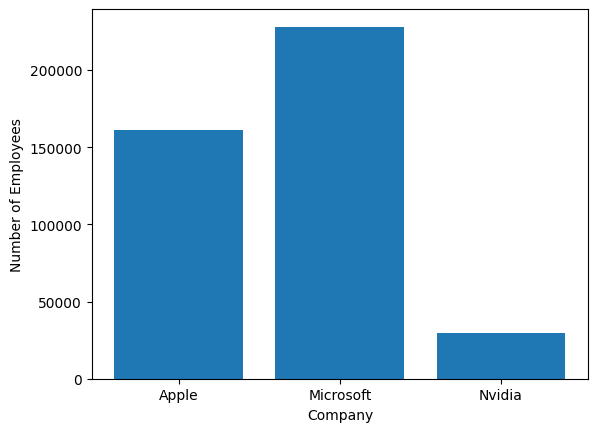

In [68]:
agent_executor.invoke({
    "input": "Create a plot of the number of full time employees at the three tech companies with the highest market cap in the United States in 2024.",
})

In [ ]:
# notice that the model did websearch calls, then used python to do some analysis
# the model can even self-debug itself if the python code was wrong

# Let's ask another question to the data analyst -- which requires a direct answer

In [69]:
agent_executor.invoke({
    "input": "Hey how are you?",
})


I will respond to the user's greeting.
{'tool_name': 'directly_answer', 'parameters': {}}
directly_answer is not a valid tool, try one of [internet_search, python_interpreter].Relevant Documents: None
Cited Documents: None
Answer: I'm an AI assistant, so I don't have feelings as such, but I'm here to help! How can I assist you today?
Grounded answer: I'm an AI assistant, so I don't have feelings as such, but I'm here to help! How can I assist you today?

> Finished chain.


{'input': 'Hey how are you?',
 'output': "I'm an AI assistant, so I don't have feelings as such, but I'm here to help! How can I assist you today?",
 'citations': []}

This is a simple example to get you start. There [are many tools](https://python.langchain.com/docs/integrations/tools/) you can equip your agent with. Once youre comfortable with these ideas, you can also proceed to define your tools (see [Multi-step tool use in Action](https://docs.cohere.com/docs/multi-step-tool-use#multi-step-tool-use-in-action)).


In [70]:
%pip install --upgrade --quiet  googlemaps langchain-community

  Preparing metadata (setup.py) ... done


In [ ]:
import os

os.environ["GPLACES_API_KEY"] = ""